100%|██████████| 26.4M/26.4M [00:00<00:00, 116MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 4.85MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 60.0MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.0MB/s]



OscillatingLR | Epoch [1/10] | Loss: 0.5335
OscillatingLR | Epoch [2/10] | Loss: 0.3188
OscillatingLR | Epoch [3/10] | Loss: 0.2722
OscillatingLR | Epoch [4/10] | Loss: 0.2398
OscillatingLR | Epoch [5/10] | Loss: 0.2164
OscillatingLR | Epoch [6/10] | Loss: 0.1981
OscillatingLR | Epoch [7/10] | Loss: 0.1805
OscillatingLR | Epoch [8/10] | Loss: 0.1646
OscillatingLR | Epoch [9/10] | Loss: 0.1478
OscillatingLR | Epoch [10/10] | Loss: 0.1326
✅ OscillatingLR Test Accuracy: 91.84% | Time: 865.0s

SGD | Epoch [1/10] | Loss: 0.5267
SGD | Epoch [2/10] | Loss: 0.3148
SGD | Epoch [3/10] | Loss: 0.2682
SGD | Epoch [4/10] | Loss: 0.2391
SGD | Epoch [5/10] | Loss: 0.2163
SGD | Epoch [6/10] | Loss: 0.1964
SGD | Epoch [7/10] | Loss: 0.1789
SGD | Epoch [8/10] | Loss: 0.1628
SGD | Epoch [9/10] | Loss: 0.1483
SGD | Epoch [10/10] | Loss: 0.1335
✅ SGD Test Accuracy: 91.93% | Time: 902.7s

Adam | Epoch [1/10] | Loss: 0.5217
Adam | Epoch [2/10] | Loss: 0.3803
Adam | Epoch [3/10] | Loss: 0.3510
Adam | Epoch [

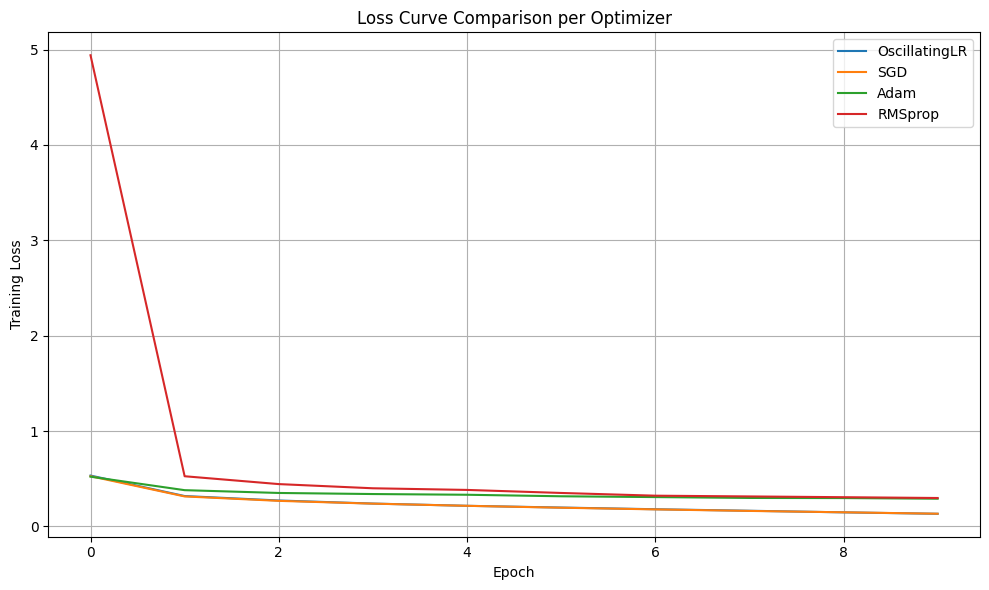

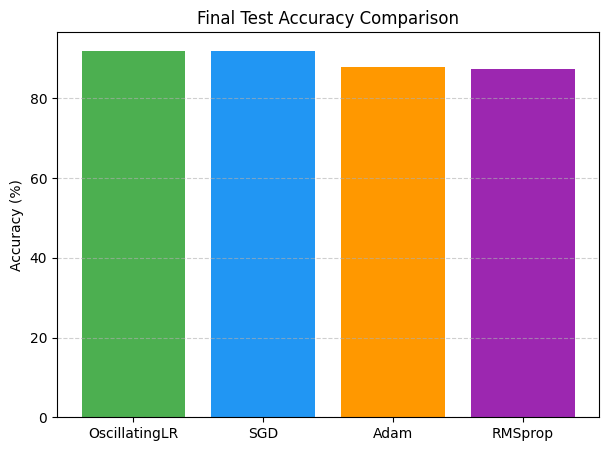

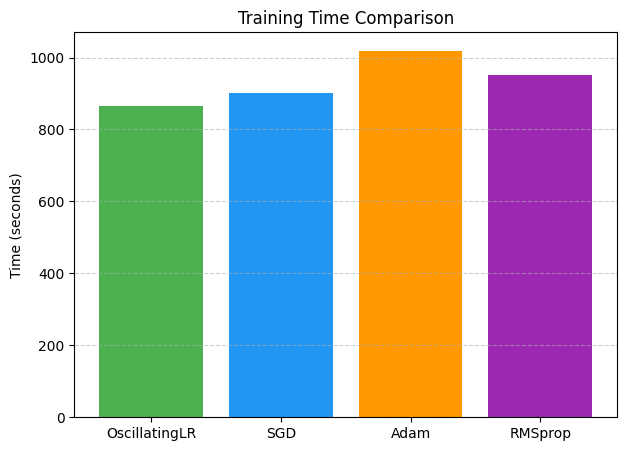


===== FINAL COMPARISON TABLE =====

    Optimizer  Accuracy (%)  Training Time (s)
          SGD         91.93         902.723857
OscillatingLR         91.84         865.022138
         Adam         87.73        1019.220199
      RMSprop         87.37         951.560291


In [1]:
# ============================================
# Optimizer Comparison: OscillatingLR vs SGD, Adam, RMSprop
# Author: (Sreelatha SK)
# ============================================
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np, random, time, pandas as pd

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ----------------------------
# Custom OscillatingLR Optimizer
# ----------------------------
class OscillatingLR(optim.Optimizer):
    def __init__(self, params, base_lr=0.01, oscillation_factor=0.005, momentum=0.9):
        self.base_lr = base_lr
        self.oscillation_factor = oscillation_factor
        self.momentum = momentum
        self.step_count = 0
        defaults = dict(momentum=momentum)
        super(OscillatingLR, self).__init__(params, defaults)
        for group in self.param_groups:
            for param in group['params']:
                self.state[param] = {'velocity': torch.zeros_like(param)}

    def step(self, closure=None):
        self.step_count += 1
        lr = self.base_lr + self.oscillation_factor * (-1) ** self.step_count
        for group in self.param_groups:
            momentum = group['momentum']
            for param in group['params']:
                if param.grad is not None:
                    velocity = self.state[param]['velocity']
                    velocity.mul_(momentum).add_(param.grad)
                    param.data -= lr * velocity
                    self.state[param]['velocity'] = velocity
        if closure is not None:
            return closure()
        return lr

# ----------------------------
# CNN Model Definition
# ----------------------------
class FashionMNISTCNN(nn.Module):
    def __init__(self):
        super(FashionMNISTCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ----------------------------
# Data Preparation
# ----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Training + Evaluation Function
# ----------------------------
def train_and_evaluate(optimizer_name, optimizer_class, **optimizer_params):
    model = FashionMNISTCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), **optimizer_params)

    num_epochs = 10
    epoch_losses = []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"{optimizer_name} | Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f}")

    # Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    elapsed = time.time() - start_time
    print(f"✅ {optimizer_name} Test Accuracy: {accuracy:.2f}% | Time: {elapsed:.1f}s")
    return accuracy, epoch_losses, elapsed

# ----------------------------
# Run Comparisons
# ----------------------------
optimizers = {
    "OscillatingLR": (OscillatingLR, {"base_lr": 0.01, "oscillation_factor": 0.005, "momentum": 0.9}),
    "SGD": (optim.SGD, {"lr": 0.01, "momentum": 0.9}),
    "Adam": (optim.Adam, {"lr": 0.01}),
    "RMSprop": (optim.RMSprop, {"lr": 0.01})
}

results, loss_logs, times = {}, {}, {}

for name, (opt_class, opt_params) in optimizers.items():
    print("\n" + "="*60)
    acc, losses, elapsed = train_and_evaluate(name, opt_class, **opt_params)
    results[name] = acc
    loss_logs[name] = losses
    times[name] = elapsed

# ----------------------------
# Visualization
# ----------------------------
plt.figure(figsize=(10, 6))
for name, losses in loss_logs.items():
    plt.plot(losses, label=name)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss Curve Comparison per Optimizer")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Accuracy Comparison Bar Chart
plt.figure(figsize=(7,5))
plt.bar(results.keys(), results.values(), color=['#4CAF50','#2196F3','#FF9800','#9C27B0'])
plt.title("Final Test Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Training Time Bar Chart
plt.figure(figsize=(7,5))
plt.bar(times.keys(), times.values(), color=['#4CAF50','#2196F3','#FF9800','#9C27B0'])
plt.title("Training Time Comparison")
plt.ylabel("Time (seconds)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# ----------------------------
# Summary Table
# ----------------------------
df = pd.DataFrame({
    "Optimizer": results.keys(),
    "Accuracy (%)": results.values(),
    "Training Time (s)": times.values()
})
df = df.sort_values("Accuracy (%)", ascending=False).reset_index(drop=True)
print("\n===== FINAL COMPARISON TABLE =====\n")
print(df.to_string(index=False))
